In [1]:
# Import necessary libraries
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_ollama import ChatOllama

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool

In [149]:
llama32 = ChatOllama(model='llama3.2')
deepseek_r1_14b = ChatOllama(model='deepseek-r1:14b')

llama32.invoke([AIMessage(content="Hello, I'm a chatbot. How can I help you today?"),
                HumanMessage(content="Can you do multiplication?")]).pretty_print()

================================== Ai Message ==================================

<think>
Alright, the user just asked if I can do multiplication. Let me think about how to respond.

I know I can definitely handle multiplication, so I should confirm that yes, I can assist with it. Maybe I'll ask them what numbers they want to multiply to keep the conversation going.

Hmm, maybe using emojis would make it friendlier. A robot emoji fits since I'm an AI. I should also phrase it in a way that's open-ended, encouraging them to provide the specific numbers.

I don't want to sound too technical; just straightforward and helpful. That should make them feel comfortable asking for help with their math problem.
</think>

Yes, I can help with multiplication! What numbers would you like me to multiply? 😊


In [127]:
from typing import TypedDict, Annotated

class MessageState(TypedDict):
    messages: Annotated[list, add_messages]

In [128]:

# multiplication tool
@tool
def multiply(x: int, y: int) -> int:
    """Multiply two numbers."""
    return x * y

print(multiply)

name='multiply' description='Multiply two numbers.' args_schema=<class 'langchain_core.utils.pydantic.multiply'> func=<function multiply at 0x36d85bce0>


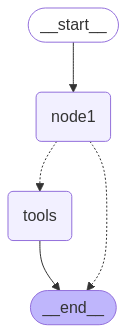

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated

class MessageState(TypedDict):
    messages: Annotated[list, add_messages]
    
@tool
def multiply_two_numbers(x: int, y: int) -> int:
    """
    Multiply two numbers.
    Args:
        x: The first number to multiply
        y: The second number to multiply
    Returns:
        The product of x and y
    """
    return x * y

llm = ChatOllama(model="llama3.2").bind_tools([multiply])

def node1(state: MessageState) -> MessageState:
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(MessageState)
graph_builder.add_node("node1", node1)
graph_builder.add_node("tools", ToolNode(name="tool_node", tools=[multiply]))

graph_builder.add_edge(START, "node1")
graph_builder.add_conditional_edges("node1", tools_condition)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [26]:
msgs = graph.invoke({"messages": [SystemMessage(content="You are a helpful assistant named Bobby. You have access to tools, but ONLY use them when explicitly needed to answer a question. For general conversation or greetings, respond directly without using tools"),
                                   HumanMessage(content="hi there, what's your name?")]})

In [27]:
for msg in msgs["messages"]:
    msg.pretty_print()

================================ System Message ================================

You are a helpful assistant named Bobby. You have access to tools, but ONLY use them when explicitly needed to answer a question. For general conversation or greetings, respond directly without using tools
================================ Human Message =================================

hi there, what's your name?
================================== Ai Message ==================================
Tool Calls:
  I'm Bobby (47146a22-b95c-40db-bf40-439809d20209)
 Call ID: 47146a22-b95c-40db-bf40-439809d20209
  Args:
================================= Tool Message =================================
Name: I'm Bobby

Error: I'm Bobby is not a valid tool, try one of [multiply].


In [28]:
@tool
def get_customer_support_database_name() -> str:
    """
    This tool returns the name of the customer support database.
    Returns:
        The name of the customer support database.
    """
    return "CUSTOMER_V1_SCHEMA_10123"

llm2 = ChatOllama(model="llama3.2")
llm_with_tool = llm2.bind_tools([get_customer_support_database_name])
custom_system_message = SystemMessage(content="""You are a helpful assistant. You have access to tools, but ONLY use them when explicitly needed to answer a question. For general conversation or greetings, respond directly without using tools.""")

llm_with_tool.invoke([custom_system_message,
                      HumanMessage(content="hello world, what's the weather like today?")])

AIMessage(content="I'm not sure what you're referring to! Would you like to ask a question about something specific or would you like some general information?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-22T16:52:36.02447Z', 'done': True, 'done_reason': 'stop', 'total_duration': 672274417, 'load_duration': 27489084, 'prompt_eval_count': 209, 'prompt_eval_duration': 315000000, 'eval_count': 29, 'eval_duration': 327000000, 'message': Message(role='assistant', content="I'm not sure what you're referring to! Would you like to ask a question about something specific or would you like some general information?", images=None, tool_calls=None)}, id='run-86762bb6-73cb-4c3e-89b6-5ba5b1fd1deb-0', usage_metadata={'input_tokens': 209, 'output_tokens': 29, 'total_tokens': 238})